# TextRank

In [1]:
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from IPython.display import display
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import numpy as np
import nltk
import re

nltk.download('stopwords')
nltk.download('punkt')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
corpus = stopwords.words('indonesian')
def stopwords(text):
  return ' '.join(word for word in text.split() if word not in corpus)

In [3]:
def plot_graph(G, figsize=(35, 30), node_size=700, node_color='skyblue'):
  # Menggambar graf dengan canvas yang diperbesar
  pos = nx.spring_layout(G)  # Menentukan posisi simpul
  labels = nx.get_edge_attributes(G, 'weight')

  # Menentukan ukuran canvas
  plt.figure(figsize=figsize)

  # Menggambar graf dengan ukuran canvas yang diperbesar
  nx.draw(G, pos, with_labels=True, node_size=node_size, node_color=node_color)
  nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_color='red')
  plt.show()

In [4]:
def graph_co_occurrence(x, show_matrics=False):
  vectorizer = CountVectorizer()
  tfidf_matrics = vectorizer.fit_transform(x)
  co_occurrence_matrix = tfidf_matrics.T.dot(tfidf_matrics).toarray()
  df_co_occurence = pd.DataFrame(co_occurrence_matrix, columns=vectorizer.get_feature_names_out())
  df_co_occurence.insert(0, 'Word', vectorizer.get_feature_names_out())

  if show_matrics:
    print("Tabel Co-occurence Matrics: ")
    display(df_co_occurence)
    print()

  # Membuat graf berbobot menggunakan NetworkX
  G = nx.DiGraph()
  num_words = co_occurrence_matrix.shape[0]

  # Menambahkan edge ke graf berdasarkan matriks co-occurrence
  for i in range(num_words):
    for j in range(i + 1, num_words):
      weight = co_occurrence_matrix[i, j]
      if weight > 0:
        G.add_edge(vectorizer.get_feature_names_out()[i], vectorizer.get_feature_names_out()[j], weight=weight)
  return G

In [5]:
def text_rank(graph, damping_factor=0.85, max_iter=100, tol=1e-4):
  # Inisialisasi nilai TextRank untuk setiap node
  initial_value = 1 / graph.number_of_nodes()
  ranks = {node: initial_value for node in graph.nodes()}

  print(f"Inisialisasi Score Awal : {ranks}")
  print(f"Edges : {graph.edges()}")
  print()

  for i in range(max_iter):
    new_ranks = {}
    print(f"========== Iterasi Ke - {i} ==========")

    for node in graph.nodes():
      rank_sum = 0
      operasi = ''

      # Menampilkan informasi out_sum dan win untuk setiap node dan neighbor
      out_sums_info = {}
      win = graph.in_degree(node, weight="weight")

      for neighbor in graph.predecessors(node):
        edge_weight = graph[neighbor][node]["weight"]
        out_sum = sum(graph[neighbor][out_neighbor]["weight"] for out_neighbor in graph.successors(neighbor))
        rank_sum += (edge_weight / out_sum) * ranks[neighbor]
        operasi += f"({edge_weight}/{out_sum}) * {ranks[neighbor]} + "

        # Menambah informasi out_sum untuk setiap neighbor
        out_sums_info[neighbor] = {out_neighbor: graph[neighbor][out_neighbor]["weight"] for out_neighbor in graph.successors(neighbor)}

      # Jika operasi kosong, atur nilai operasi menjadi 0
      operasi = operasi[:-3] if operasi else '0'

      new_rank = (1 - damping_factor) + damping_factor * rank_sum
      new_ranks[node] = new_rank

      # Menampilkan informasi out_sum dan win pada setiap iterasi
      print(f"Win({node}): {win}")
      print(f"Out_sums_info({node}): {out_sums_info}")
      print(f"W({node}) = (1 - {damping_factor}) + {damping_factor} * ({operasi}) = {new_rank}")
      print()

    # Periksa konvergensi
    convergence = all(abs(new_ranks[node] - ranks[node]) < tol for node in graph.nodes())
    ranks = new_ranks
    print(f"New Score : {new_ranks}")
    print()

    if convergence:
      print(f"Konvergensi tercapai pada iterasi ke-{i}")
      break

  return ranks

In [6]:
def extract_top_words(x, w=3, show_matrics=False, show_scores=False, index=None):
    full_text = ' '.join(word for word in x)

    # Stopwords removal
    x = [stopwords(full_text)]

    G = graph_co_occurrence(x, show_matrics)

    # Menghitung nilai dari PageRank (TextRank)
    scores = text_rank(G)

    # Dictionary untuk menyimpan skor tertinggi setiap kata
    ranked_words_dict = {}

    for word in ' '.join(x).split():
        current_score = scores.get(word, 0)
        if word not in ranked_words_dict or current_score > ranked_words_dict[word]:
            ranked_words_dict[word] = current_score

    # Mengurutkan kata-kata berdasarkan skor tertinggi
    ranked_words = sorted(((score, word) for word, score in ranked_words_dict.items()), key=lambda x: (x[0], x[1]), reverse=True)

    # Memilih sejumlah w kata tertinggi
    selected_words = [word for _, word in ranked_words[:w]] if w is not None else None

    # Menggabungkan kata-kata menjadi satu string terpisah dengan koma
    keywords = ', '.join(selected_words) if selected_words else ''

    if show_scores:
      print(f'Dokumen ke {index} : {full_text}')
      print(f'{w} Kata Kunci : {keywords}')
      print("TextRank Scores:")
      for score, word in ranked_words:
          print(f"Skor: {score}, Kata: {word}")

    return (G, selected_words)

In [7]:
text1 = ['pemandangan gunung semeru indah']
G1, keywords1 = extract_top_words(text1, w=2, show_matrics=True)

Tabel Co-occurence Matrics: 


,Word,gunung,indah,pemandangan,semeru
0,gunung,1,1,1,1
1,indah,1,1,1,1
2,pemandangan,1,1,1,1
3,semeru,1,1,1,1



Inisialisasi Score Awal : {'gunung': 0.25, 'indah': 0.25, 'pemandangan': 0.25, 'semeru': 0.25}
Edges : [('gunung', 'indah'), ('gunung', 'pemandangan'), ('gunung', 'semeru'), ('indah', 'pemandangan'), ('indah', 'semeru'), ('pemandangan', 'semeru')]

========== Iterasi Ke - 0 ==========
Win(gunung): 0
Out_sums_info(gunung): {}
W(gunung) = (1 - 0.85) + 0.85 * (0) = 0.15000000000000002

Win(indah): 1
Out_sums_info(indah): {'gunung': {'indah': 1, 'pemandangan': 1, 'semeru': 1}}
W(indah) = (1 - 0.85) + 0.85 * ((1/3) * 0.25) = 0.22083333333333335

Win(pemandangan): 2
Out_sums_info(pemandangan): {'gunung': {'indah': 1, 'pemandangan': 1, 'semeru': 1}, 'indah': {'pemandangan': 1, 'semeru': 1}}
W(pemandangan) = (1 - 0.85) + 0.85 * ((1/3) * 0.25 + (1/2) * 0.25) = 0.32708333333333334

Win(semeru): 3
Out_sums_info(semeru): {'gunung': {'indah': 1, 'pemandangan': 1, 'semeru': 1}, 'indah': {'pemandangan': 1, 'semeru': 1}, 'pemandangan': {'semeru': 1}}
W(semeru) = (1 - 0.85) + 0.85 * ((1/3) * 0.25 + (1

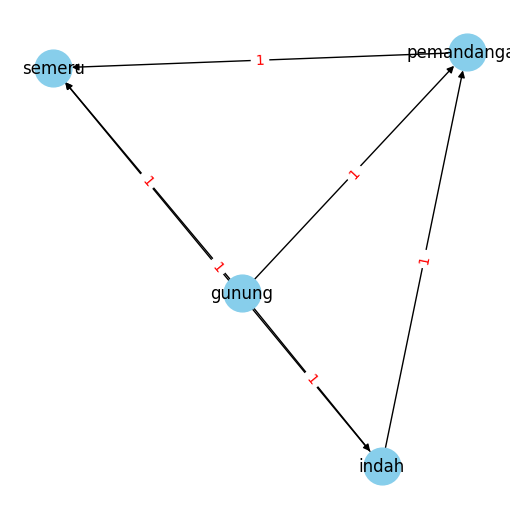

In [8]:
plot_graph(G1, figsize=(5, 5), node_size=700,)

In [9]:
keywords1

['semeru', 'pemandangan']

## TextRank

In [10]:
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from IPython.display import display
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import numpy as np
import nltk
import re

nltk.download('stopwords')
nltk.download('punkt')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
df = pd.read_csv('https://raw.githubusercontent.com/MeAdila/ppw/gh-pages/berita-BBC.csv')
df

,Judul Berita,Isi Berita,Kategori Berita
0,Viral penemuan lima mayat di Kampus Unpri Meda...,Viral penemuan lima mayat di Kampus Unpri Meda...,Indonesia
1,Debat capres berpengaruh terhadap pemilih meng...,Debat capres berpengaruh terhadap pemilih meng...,Indonesia
2,"Pilpres 2024: Apa janji capres soal hukum, HAM...","Pilpres 2024: Apa janji capres soal hukum, HAM...",Indonesia
3,TikTok Shop buka lagi setelah akuisisi Tokoped...,TikTok Shop buka lagi setelah akuisisi Tokoped...,Indonesia
4,Siapa yang menyebarkan narasi kebencian dan ho...,Siapa yang menyebarkan narasi kebencian dan ho...,Indonesia
...,...,...,...
715,Demonstrasi anti-LGBT warnai konser Coldplay d...,Demonstrasi anti-LGBT warnai konser Coldplay d...,Viral
716,"SEA Games 2023 'dihujani kritik', apa yang seb...","SEA Games 2023 'dihujani kritik', apa yang seb...",Viral
717,"Fenomena ‘garasi’ di jalan umum, mengapa selal...","SEA Games 2023 'dihujani kritik', apa yang seb...",Viral
718,Presiden Jokowi ambil alih perbaikan jalan di ...,"SEA Games 2023 'dihujani kritik', apa yang seb...",Viral


In [12]:
df.isnull().sum()

Judul Berita       0
Isi Berita         0
Kategori Berita    0
dtype: int64

In [13]:
def cleaning(text):
  text = re.sub(r'[^\w\s.?!,]', '', text).strip().lower()
  return text

df['Cleaning'] = df['Isi Berita'].apply(cleaning)
df['Cleaning']

0      viral penemuan lima mayat di kampus unpri meda...
1      debat capres berpengaruh terhadap pemilih meng...
2      pilpres 2024 apa janji capres soal hukum, ham,...
3      tiktok shop buka lagi setelah akuisisi tokoped...
4      siapa yang menyebarkan narasi kebencian dan ho...
                             ...                        
715    demonstrasi antilgbt warnai konser coldplay di...
716    sea games 2023 dihujani kritik, apa yang seben...
717    sea games 2023 dihujani kritik, apa yang seben...
718    sea games 2023 dihujani kritik, apa yang seben...
719    polda lampung hentikan kasus tiktoker bima, pa...
Name: Cleaning, Length: 720, dtype: object

In [14]:
corpus = stopwords.words('indonesian')

def stopwordText(text):
  return ' '.join(word for word in text.split() if word not in corpus)

df['Stopword Removal'] = df['Cleaning'].apply(stopwordText)

In [15]:
def tokenizer(text):
  text = text.lower()
  return sent_tokenize(text)

df['Tokenizing'] = df['Stopword Removal'].apply(tokenizer)
df['Tokenizing']

0      [viral penemuan mayat kampus unpri medan korba...
1      [debat capres berpengaruh pemilih mengambang?s...
2      [pilpres 2024 janji capres hukum, ham, korupsi...
3      [tiktok shop buka akuisisi tokopedia, pedagang...
4      [menyebarkan narasi kebencian hoaks rohingya m...
                             ...                        
715    [demonstrasi antilgbt warnai konser coldplay j...
716    [sea games 2023 dihujani kritik, kamboja?sumbe...
717    [sea games 2023 dihujani kritik, kamboja?sumbe...
718    [sea games 2023 dihujani kritik, kamboja?sumbe...
719    [polda lampung hentikan tiktoker bima, pakar u...
Name: Tokenizing, Length: 720, dtype: object

In [16]:
def plot_graph(G, figsize=(35, 30), node_size=700, node_color='skyblue'):
  # Menggambar graf dengan canvas yang diperbesar
  pos = nx.spring_layout(G)  # Menentukan posisi simpul
  labels = nx.get_edge_attributes(G, 'weight')

  # Menentukan ukuran canvas
  plt.figure(figsize=(35, 30))

  # Menggambar graf dengan ukuran canvas yang diperbesar
  nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue')
  nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_color='red')
  plt.show()

In [17]:
def graph_co_occurrence(x, threshold=0, show_matrics = False):
    vectorizer = CountVectorizer()
    tfidf_matrics = vectorizer.fit_transform(x)
    co_occurrence_matrix = tfidf_matrics.T.dot(tfidf_matrics).toarray()
    df_co_occurence = pd.DataFrame(co_occurrence_matrix, columns=vectorizer.get_feature_names_out())

    if show_matrics:
      display(df_co_occurence)

    G = nx.DiGraph()

    # Menambahkan edge ke graf berdasarkan matriks co-occurrence
    for i in range(len(co_occurrence_matrix)):
      for j in range(i + 1, len(co_occurrence_matrix)):
        weight = co_occurrence_matrix[i, j]
        if weight > threshold:
          G.add_edge(vectorizer.get_feature_names_out()[i], vectorizer.get_feature_names_out()[j], weight=weight)
    return G

In [18]:
def extract_top_words(x, w=3, threshold=0, show_matrics=False, show_scores=False, index=None):
    full_text = ' '.join(word for word in x)

    G = graph_co_occurrence(x, threshold, show_matrics)

    # Menghitung nilai dari PageRank (TextRank)
    scores = nx.pagerank(G)

    # Dictionary untuk menyimpan skor tertinggi setiap kata
    ranked_words_dict = {}

    for word in ' '.join(x).split():
        current_score = scores.get(word, 0)
        if word not in ranked_words_dict or current_score > ranked_words_dict[word]:
            ranked_words_dict[word] = current_score

    # Mengurutkan kata-kata berdasarkan skor tertinggi
    ranked_words = sorted(((score, word) for word, score in ranked_words_dict.items()), key=lambda x: (x[0], x[1]), reverse=True)

    # Memilih sejumlah w kata tertinggi
    selected_words = [word for _, word in sorted(ranked_words[:w], key=lambda x: x[1])] if w is not None else None

    # Menggabungkan kata-kata menjadi satu string terpisah dengan koma
    keywords = ', '.join(selected_words) if selected_words else ''

    if show_scores:
      print(f'Dokumen ke {index} : {full_text}')
      print(f'{w} Kata Kunci : {keywords}')
      print("TextRank Scores:")
      for score, word in ranked_words:
          print(f"Skor: {score}, Kata: {word}")

    return (G, selected_words)

In [19]:
def extract_all(x, w=4, plot=False, show_matrics=False, show_scores=False, index=1, threshold=0):

  # G = graph_co_occurrence(x, show_matrics)

  G, top_words = extract_top_words(x, w, threshold, show_matrics, show_scores, index)

  if plot:
    print()
    print("Plot Graph :")
    plot_graph(G)

  # Menggabungkan kata-kata menjadi satu string terpisah dengan koma
  keywords = ', '.join(top_words) if top_words else ''

  return keywords

In [20]:
example = df["Tokenizing"].iloc[1]
example

['debat capres berpengaruh pemilih mengambang?sumber gambar, fotoketerangan gambar, capres nomor urut anies baswedan kanan, capres nomor urut prabowo subianto tengah, capres nomor urut ganjar pranowo kiri beradu gagasan debat perdana capres cawapres 2024 gedung kpu, jakarta, selasa 12122023. debat perdana mengangkat topik pemerintahan, hukum ham, pemberantasan korupsi, penguatan demokrasi, peninngkatan layanan publik kerukunan warga.13 desember 2023, 0713 wibdebat caprescawapres dinilai berpengaruh elektabilitas pasangan calon, pengamat.',
 'tetapi, tim sukses caprescawapres debat elektabilitas calon.pendiri saiful mujani research and consulting smrc, saiful mujani, menyimpulkan berdasarkan kajian elektabilitas lakukan debat caprescawapres berpengaruh signifikan suara pemilih.kalau mengukur elektabilitas hasil survei debat hasil survei debat, rangkaian pilpres 2004 2019 kemarin, pengaruh debat sebenarnya, jelasnya.sebab, orangorang menonton debat cenderung pengikut setia alias partisan

In [21]:
keyword =  extract_all(example, w=3, show_matrics=True, plot=True, show_scores=True, index=1)

Output hidden; open in https://colab.research.google.com to view.